## Seq2Seq with PyTorch

* Task: "translating to the next sequence". E.g. ['ABC','BBA','BCE'] -> ['ABD','BBB','BCF'].
* Type: Attention (Bahdanau et al. 2015; Luong et al. 2016); Residual links and stacking (Prakash et al. 2016).
* PyTorch version: 0.3.1

In [1]:
import os
import dill
import random
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from nltk.translate.bleu_score import sentence_bleu as bleu
from nltk.translate.bleu_score import SmoothingFunction

SMOOTH = SmoothingFunction()

### Data Prep

In [2]:
class Indexer:
    """Word <-> Index mapper."""

    def __init__(self, specialTokenList=None):
        self.word2index = {}
        self.index2word = {}
        self.wordSet = set()
        self.size = 0
        if specialTokenList is not None:
            assert type(specialTokenList)==list
            for token in specialTokenList:
                self.get_index(token, add=True)

    def __repr__(self):
        return "The indexer currently has %d words" % self.size

    def get_word(self, index):
        return self.index2word[index] if index<self.size else 'UNK'

    def get_index(self, word, add=True):
        if add and word not in self.wordSet:
            self.word2index[word] = self.size
            self.index2word[self.size] = word
            self.wordSet.add(word)
            self.size += 1
        return self.word2index[word] if word in self.wordSet else self.word2index['UNK']

    def contains(self, word):
        return word in self.wordSet

    def add_sentence(self, sentence, returnIndices=True):
        indices = [self.get_index(word, add=True) for word in sentence.split()]
        return (indices,len(indices)) if returnIndices else None

    def add_document(self, docPath, returnIndices=True):
        with open(docPath, 'r') as doc:
            if returnIndices:
                indicesList, lengthList = [], []
                for line in doc:
                    indices,length = self.add_sentence(line,returnIndices)
                    if length<=0: continue # handle bad sentences in .txt.
                    indicesList.append(indices)
                    lengthList.append(length)
                return indicesList, lengthList
            else:
                for line in doc:
                    self.add_sentence(line,returnIndices=False)
                return None
    
    def to_words(self, indices):
        return [self.get_word(index) for index in indices]
    
    def to_sent(self, indices):
        return ' '.join(self.to_words(indices))
    
    def to_indices(self, words):
        return [self.get_index(word) for word in words]

class DataIterator:
    """Data feeder by batch."""

    def __init__(self, indexer, pairs, lengths):
        """
        Args:
            indexer: an Indexer object.
            pairs: a list of pairs of token index lists.
            lengths: a list of pairs of sentence length lists.
        """
        self.indexer = indexer
        self.pairs = pairs
        self.lengths = lengths
        self.size = len(pairs)
        self.indices = range(self.size)

    def _get_padded_sentence(self, index, maxSentLen, maxTargetLen):
        """Pad a sentence pair by EOS (pad both to the largest length of respective batch).

        Args:
            index: index of a sentence & length pair in self.pairs, self.lengths.
            maxSentLen: the length of the longest source sentence.
            maxTargetLen: the length of the longest target sentence.
        Returns:
            padded source sentence (list), its length (int), 
            padded target sentence (list), its length (int).
        """
        sent1,sent2 = self.pairs[index][0], self.pairs[index][1]
        length1,length2 = self.lengths[index][0], self.lengths[index][1]
        paddedSent1 = sent1[:maxSentLen] if length1>maxSentLen else sent1+[self.indexer.get_index('EOS')]*(maxSentLen-length1)
        paddedSent2 = sent2[:maxTargetLen] if length2>maxTargetLen else sent2+[self.indexer.get_index('EOS')]*(maxTargetLen-length2)
        return paddedSent1,length1,paddedSent2,length2

    def random_batch(self, batchSize):
        """Random batching.

        Args:
            batchSize: size of a batch of sentence pairs and respective lengths.
        Returns:
            the batch of source sentence (Variable(torch.LongTensor())),
            the lengths of source sentences (numpy.array())
            and the same for target sentences and lengths.
        """
        batchIndices = np.random.choice(self.indices, size=batchSize, replace=False)
        batchSents,batchTargets,batchSentLens,batchTargetLens = [], [], [], []
        maxSentLen, maxTargetLen = np.array([self.lengths[index] for index in batchIndices]).max(axis=0)
        for index in batchIndices:
            paddedSent1,length1,paddedSent2,length2 = self._get_padded_sentence(index, maxSentLen, maxTargetLen)
            batchSents.append(paddedSent1)
            batchTargets.append(paddedSent2)
            batchSentLens.append(length1)
            batchTargetLens.append(length2)
        batchIndices = range(batchSize) # reindex from 0 for sorting.
        batchIndices = [i for i,l in sorted(zip(batchIndices,batchSentLens),key=lambda p:p[1],reverse=True)]
        batchSents = Variable(torch.LongTensor(np.array(batchSents)[batchIndices])).transpose(0,1) # <bc,mt> -> <mt,bc>
        batchTargets = Variable(torch.LongTensor(np.array(batchTargets)[batchIndices])).transpose(0,1)
        batchSentLens = np.array(batchSentLens)[batchIndices]
        batchTargetLens = np.array(batchTargetLens)[batchIndices]
        return batchSents, batchSentLens, batchTargets, batchTargetLens
        
class DataLoader:
    
    def __init__(self, dataDir):
        self.dataDir = dataDir # str
        self.dataDict = {path.split('.')[0]:self.dataDir+path
                         for path in os.listdir(self.dataDir) if path.endswith('.txt')}
        self.filenames = set(['train_source', 'train_target',
                              'test_source', 'test_target'])
        if self._filename_mismatch():
            raise Exception("Expected filenames under the directory:\n"+str(self.filenames)+
                            '\nGot:\n'+str(self.dataDict.keys())+'\n')
    
    def _filename_mismatch(self):
        return self.filenames - set(self.dataDict.keys()) != set([])
    
class TranslationDataLoader(DataLoader):
    
    def __init__(self, dataDir):
        DataLoader.__init__(self, dataDir)
    
    def load(self, specialTokenList=None):
        indexer = Indexer(specialTokenList)
        print "... loading training data."
        trainPairs,trainLens = self._load_pairs(indexer,
                                                self.dataDict['train_source'],
                                                self.dataDict['train_target'])
        print "... loading test data."
        testPairs,testLens = self._load_pairs(indexer,
                                              self.dataDict['test_source'],
                                              self.dataDict['test_target'])
        print "Done!\n"
        return indexer,trainPairs,trainLens,testPairs,testLens

    def _load_pairs(self, indexer, sourcePath, targetPath):
        sourceSents,sourceLens = indexer.add_document(sourcePath,returnIndices=True)
        targetSents,targetLens = indexer.add_document(targetPath,returnIndices=True)
        return zip(sourceSents, targetSents), zip(sourceLens, targetLens)

class ToyDataGenerator:
    """Generate toy translation dataset: translation to the next letter.
       E.g. ['A','B','C'] -> ['B','C','D'].
    """
    
    def __init__(self, vocab, dataSize, fromLen, toLen, cutoff,
                 trainSourcePath, trainTargetPath, testSourcePath, testTargetPath):
        """
        
        Args:
            vocab: a list of vocabulary words (in strings).
            dataSize: #entries for train + test.
            fromLen, toLen: length range of generated sentences.
            cutoff: a float between 0. and 1., proportion of training data.
            train/testSource/Path: path to saved generation.
        """
        self.vocab = vocab
        self.dataSize = dataSize
        self.fromLen = fromLen
        self.toLen = toLen
        self.cutoffIndex = (int)(cutoff*dataSize)
        self.trainSourcePath = trainSourcePath
        self.trainTargetPath = trainTargetPath
        self.testSourcePath = testSourcePath
        self.testTargetPath = testTargetPath
    
    def translate_word(self, word):
        """Find the next letter.

        Args:
            word: a letter word (e.g. 'A').
        Returns:
            The next letter to word.
        """
        return self.vocab[self.vocab.index(word)+1]
    
    def translate_sent(self, sent):
        """Find the next-letter translation of a sentence.

        Args:
            sent: a list of letter words.
        Returns:
            The next letters.
        """
        return [self.translate_word(word) for word in sent]
    
    def writeSentToFile(self, path, sent, mode):
        """Write one sentence to a file (given path).
        
        Args:
            path: path to file.
            sent: a single-string sentence.
            mode: either 'a' (append) or 'w' (write).
        """
        with open(path, mode) as f:
            f.write(sent)
            f.write('\n')
    
    def writeDataSet(self, sourcePath, targetPath, size):
        """Write train/test dataset to given source/target path (given size).
        
        Args:
            SourcePath, targetPath: paths to files.
            size: #entries.
        """
        for i in range(size):
            randInput,randTarget = self.generate_pair()
            self.writeSentToFile(sourcePath, ' '.join(randInput), mode='a' if os.path.exists(sourcePath) else 'w')
            self.writeSentToFile(targetPath, ' '.join(randTarget), mode='a' if os.path.exists(targetPath) else 'w')            
    
    def generate_pair(self):
        """Randomly generate a pair of sentences (arg1 translates to arg2).

        Returns:
            randInput: a list of letter words.
            randTarget: a list of translation letter words of randInput.
        """        
        randInput = list(np.random.choice(self.vocab[:-1], size=random.randint(self.fromLen,self.toLen)))
        randTarget = self.translate_sent(randInput)
        return randInput, randTarget+[str('EOS')]
    
    def generate_data(self):
        """Randomly generate a set of pairs of sentences (arg1 translates to arg2).

        Returns:
            pairs: a pair of lists of torch Variables (torch.LongTensor).
            lengths: lengths of the corresponding lists in pairs.
        """
        print '... generating training data'
        self.writeDataSet(self.trainSourcePath, self.trainTargetPath, self.cutoffIndex)
        print '... generating test data'
        self.writeDataSet(self.testSourcePath, self.testTargetPath, self.dataSize-self.cutoffIndex)
        print 'DONE!\n'

In [246]:
def three_letterers(vocab):
    # NB: I know there's better ways to make this,
    #     but too lazy to remember the permutation algorithm. :D
    res = []
    for a in vocab:
        for b in vocab:
            for c in vocab:
                res.append(a+b+c)
    return res

vocab = three_letterers([chr(i) for i in range(65,80)]) # 3375 in vocab size later
    # NB: make it harder if you want. I tried 20k vocab, works but it trains slower.

In [248]:
if not os.path.isdir('toy'):
    os.makedirs('toy') 
tg = ToyDataGenerator(vocab=vocab,
                      dataSize=5000,
                      fromLen=10, toLen=20,
                      cutoff=0.8,
                      trainSourcePath='toy/train_source.txt',
                      trainTargetPath='toy/train_target.txt',
                      testSourcePath='toy/test_source.txt',
                      testTargetPath='toy/test_target.txt')
tg.generate_data()

... generating training data
... generating test data
DONE!



In [3]:
trans = TranslationDataLoader('toy/')
indexer,trainPairs,trainLens,testPairs,testLens = trans.load(specialTokenList=['EOS','SOS','PAD','UNK'])

... loading training data.
... loading test data.
Done!



In [4]:
a,b = trainPairs[0]
print indexer.to_words(a)
print indexer.to_words(b)

['HLB', 'MGL', 'LLI', 'NJD', 'OHE', 'DBK', 'LAE', 'MEE', 'JGA', 'EKN', 'GLC', 'IKO', 'COD', 'KIN', 'JKK', 'FGO', 'GKI', 'GGM']
['HLC', 'MGM', 'LLJ', 'NJE', 'OHF', 'DBL', 'LAF', 'MEF', 'JGB', 'EKO', 'GLD', 'ILA', 'COE', 'KIO', 'JKL', 'FHA', 'GKJ', 'GGN', 'EOS']


### Model

In [169]:
# NB: shorthand shape annotation. 
#   `mt` = max-time/sequence-length; 
#   `bc` = batch-size; 
#   `emb` = embedding-size;
#   `h` = hidden-size;
#   `n_layer`, `n_dir`: #layers, #directions.

class Encoder(nn.Module):
    """GRU encoder"""
    
    def __init__(self, inputSize, embeddingSize, hiddenSize, 
                 nLayers=2, dropout=0.1, bidirectional=True):
        """
        
        Args:
            inputSize: vocabulary size.
            embeddingSize: size of word embedding.
            hiddenSize: size of RNN hidden state.
            nLayers: number of stacked layers.
            dropout: dropout rate.
            bidirectional: boolean.
        """
        super(Encoder, self).__init__()
        # save params
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.embeddingSize = embeddingSize
        self.nLayers = nLayers
        self.dropout = dropout
        self.bidirectional = bidirectional
        # build arc
        self.embeddings = nn.Embedding(self.inputSize, self.embeddingSize)
        self.gru = nn.GRU(self.embeddingSize, self.hiddenSize, 
                          num_layers=self.nLayers, dropout=self.dropout, bidirectional=self.bidirectional)
    
    def forward(self, batchInput, batchLen, hidden=None):
        """
        
        Args:
            batchInputs: shape = <max-time(enc),batch-size>.
            batchLen: shape = <batch-size,>.
            hidden: input hidden state (initialized as None).
        """
        # bi: <mt-enc,bc>
        # bl: <bc,>
        embedded = self.embeddings(batchInput)
            # lookup: <mt-enc,bc> -> <mt-enc,bc,emb>
        packedInput = torch.nn.utils.rnn.pack_padded_sequence(embedded, batchLen)
            # 'packed' has a 'data' and a 'batch_sizes' field.
            #   'data' is a <sum(len),emb> matrix (len is real lengths, not padded).
            #   'batch_sizes' has the number of non-zero batches at each time-step.
            # e.g. for this 'inputs'
            #    2     1     3     0     2
            #    6     8     1     6     2
            #    0     7     0     8     8
            #    6     4     2     1     1
            #    1     8     1     1     1
            #    6     1     1     1     1
            #    0     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1  
            # 'data' = 22 = 7+5+4+3+3 (1's are pads corresponding to 'EOS').
            # 'batch_sizes' = [5, 5, 5, 3, 2, 1, 1].
        packedOutput, hidden = self.gru(packedInput, hidden)
            # packedOutput: <sum(bl),h*n_dir>; hidden: <n_layer*n_dir,bc,h>
        batchOutput, batchLen = torch.nn.utils.rnn.pad_packed_sequence(packedOutput)
            # batchOutput: <mt-enc,bc,h*n_dir>
            # batchLen: <bc,>      
        if self.bidirectional:
            batchOutput = torch.cat((batchOutput[:,:,:self.hiddenSize],
                                     batchOutput[:,:,self.hiddenSize:]),dim=-1)
                # <mt-enc,bc,h> cat <mt-enc,bc,h> -> <mt-enc,bc,h*n_dir=2h>
            hidden = torch.cat((hidden[:self.nLayers,:,:],
                                hidden[self.nLayers:,:,:]),dim=-1)
                # <n_layer,bc,h> cat <n_layer,bc,h> -> <n_layer,bc,h*n_dir=2h>
        return batchOutput, hidden
            # batchOutput: <mt-enc,bc,h*n_dir=2h>
            # hidden: <n_layer,bc,h*n_dir=2h>

class Attention(nn.Module):
    """Attention layer. https://github.com/tensorflow/nmt"""
    # Source: https://github.com/tensorflow/nmt
    
    def __init__(self, hiddenSize, attentionType='bahdanau'):
        """
        
        Args:
            hiddenSize: hidden size of the decoder.
            attentionType: `bahdanau` or `luong`.
        """
        super(Attention, self).__init__()
        # save params
        self.hiddenSize = hiddenSize
        self.attentionType = attentionType
        # layers for Bahdanau
        self.encoderLinear = nn.Linear(self.hiddenSize, self.hiddenSize)
        self.decoderLinear = nn.Linear(self.hiddenSize, self.hiddenSize)
        self.tanh = nn.Tanh()
        self.v = nn.Parameter(torch.rand(self.hiddenSize,1))
        # layers for Luong
        self.biLinear = nn.Linear(self.hiddenSize, self.hiddenSize)
        # general layer
        self.linear = nn.Linear(self.hiddenSize*2, self.hiddenSize)
    
    def bahdanau_score(self, encoderOutput, decoderHidden):
        """Bahdanau et al. (2015).
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
        Returns:
            The `score` as the second in Eq.4 in the nmt tutorial.
        """
        # eo: <bc,mt-enc,h> =here= <bc,mt-enc,h>
        # dh: <bc,n_layer,h> =here= <bc,1,h>        
        return torch.matmul(self.tanh(self.encoderLinear(encoderOutput)+\
                                      self.decoderLinear(decoderHidden)),self.v).transpose(1,2)
            # op1. enc-o -> <bc,mt-enc,h>; dec-h -> <bc,1,h>; add -> <bc,mt-enc,h>
            # op2. tanh, shapes retain
            # op3. <bc,mt-enc,h> x <h,1> -> <bc,mt-enc,1>
            # op4. <bc,mt-enc,1> -> <bc,1,mt-enc> (convenient weighted-sum later)
    
    def luong_score(self, encoderOutput, decoderHidden):
        """Luong et al. (2016), `Global attention`.
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
        Returns:
            The `score` as the first in Eq.4 in the nmt tutorial.        
        """
        # eo: <bc,mt-enc,h> =here= <bc,mt-enc,h>
        # dh: <bc,n_layer,h> =here= <bc,1,h> 
        return torch.bmm(self.biLinear(encoderOutput), decoderHidden.transpose(1,2)).transpose(1,2)
            # op1. linear on encoderOutput: <bc,mt-enc,h> -> <bc,mt-enc,h>
            # op2. decoderHidden transpose for bmm: <bc,1,h> -> <bc,h,1>
            # op3. bmm: <bc,mt-enc,h> x <bc,h,1> -> <bc,mt-enc,1>
            # op4. <bc,mt-enc,1> -> <bc,1,mt-enc> (convenient weighted-sum later)
    
    def score(self, encoderOutput, decoderHidden, attentionType):
        """Attention score by type.
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
            attentionType: `bahdanau` or `luong`.
        Returns:
            Score of chosen type.
        """
        assert attentionType in ['bahdanau','luong']
        if attentionType=='bahdanau':
            return self.bahdanau_score(encoderOutput, decoderHidden)
        return self.luong_score(encoderOutput, decoderHidden)
        
    def forward(self, encoderOutput, decoderHidden):
        """
        
        Args:
            encoderOutput: shape = <batch-size,max-time(enc),hidden-size.
            decoderHidden: shape = <batch-size,1,hidden-size> (1 for one step).
        Returns:
            a batch of attention vectors (as per Eq.3 in the nmt tutorial). 
        """
        # eo: <mt-enc,bc,h> =here= <mt-enc,bc,h>
        # dh: <n_layer,bc,h> =here= <1,bc,h>
        encoderOutput = encoderOutput.transpose(0,1) # <bc,mt-enc,h>
        decoderHidden = decoderHidden.transpose(0,1) # <bc,1,h>
        attentionWeights = F.softmax(self.score(encoderOutput, decoderHidden, self.attentionType),dim=-1)
            # <bc,1,mt-enc>, where sum by mt-end = 1.
        context = torch.bmm(attentionWeights, encoderOutput).squeeze()
            # op1. batch matmul: <bc,1,mt-enc> x <bc,mt-enc,h> -> <bc,1,h>
            # op2. <bc,1,h> -> <bc,h>
        return self.tanh(self.linear(torch.cat((context,decoderHidden.squeeze()),dim=-1))), \
               attentionWeights.squeeze()
            # return arg1
            #   op1. decoderHidden squeeze: <bc,1,h> -> <bc,h>
            #   op2. concat: <bc,h> cat <bc,h> -> <bc,2h>
            #   op3. final linear layer: <bc,2h> -> <bc,h>
            #   op4. final nonlinear: dim retain
            # return arg2
            #   <bc,mt-enc> attention matrix for visualization
            
class AttentionDecoder(nn.Module):
    
    def __init__(self, outputSize, embeddingSize, hiddenSize, attentionType='bahdanau',
                 nLayers=2, dropout=0.1, residual=True):
        """
        
        Args:
            outputSize: vocabulary size.
            embeddingSize: size of word embedding.
            hiddenSize: GRU hidden state size.
            attentionType: `bahdanau` or `luong`.
            nLayers: number of stacked layers.
            dropout: dropout rate.
            residual: boolean, whether establish residual link (to top layer) or not.
        """        
        # NB: hiddenSize should double if the encoder is bidirectional.
        super(AttentionDecoder, self).__init__()
        # save params
        self.outputSize = outputSize
        self.embeddingSize = embeddingSize
        self.hiddenSize = hiddenSize
        self.nLayers = nLayers
        self.dropout = dropout
        self.residual = residual
        # layers
        self.embeddings = nn.Embedding(self.outputSize, self.embeddingSize)
        self.gru = nn.GRU(self.embeddingSize, self.hiddenSize, num_layers=self.nLayers, dropout=self.dropout)
        self.residualLinear = nn.Linear(self.embeddingSize, self.hiddenSize)
        self.attention = Attention(self.hiddenSize, attentionType).cuda()
        self.linear = nn.Linear(self.hiddenSize, self.outputSize) 
        self.tanh = nn.Tanh()
        self.logSoftmax = nn.LogSoftmax(dim=-1)
    
    def forward(self, batchSingleInput, encoderOutput, prevHidden):
        # bsi: <bc,>
        # eo: <mt-enc,bc,h> =here= <mt-enc,bc,h>
        # ph: <n_layer,bc,h> =here= <1,bc,h>
        embedded = self.embeddings(batchSingleInput).unsqueeze(0)
            # op1. lookup: <bc,> -> <bc,emb>
            # op2. conform to GRU input format: <mt=1,bc,emb>
        batchSingleOutput, hidden = self.gru(embedded, prevHidden)
            # batchSingleOutput: <mt=1,bc,h>
            # hidden: <n_layer,bc,h>
        if self.residual:
            hidden = hidden + self.residualLinear(embedded)
                # op1. map input to correct space (in last dim): emb -> h
                # op2. broadcase elemwise addition
                #   <n_layer,bc,h> + <1,bc,h> = <n_layer,bc,h>
        batchAttentionVector, attentionWeights = self.attention(encoderOutput, 
                                                                hidden[-1].unsqueeze(0))
            # batchAttentionVector: <bc,2h>
            # attentionWeights: <bc,mt-enc>
            # NB: for hidden we only take the state from the last layer
        batchSingleOutput = self.logSoftmax(self.linear(batchAttentionVector))
            # op1. linear: <bc,h> -> <bc,vocab>
            # op2. log-softmax over vocab
        return batchSingleOutput, hidden, attentionWeights
            # batchSingleOutput: <bc,vocab>
            # hidden: <1,bc,h>
            # attentionWeights: <bc,mt-enc>

In [170]:
# Test run

bc = 3
emb = 9
h = 5

diter = DataIterator(indexer, trainPairs, trainLens)
s1,s2,t1,t2 = diter.random_batch(bc)
s1,t1 = s1.cuda(),t1.cuda()

e = Encoder(indexer.size, emb, h).cuda()
d = AttentionDecoder(indexer.size, emb, h*2).cuda()
eo,eh = e(s1,s2) 
dh = eh
mtl = max(t2)
di = Variable(torch.LongTensor([indexer.get_index('SOS')]*bc)).cuda()
doall = Variable(torch.zeros(mtl,bc,d.outputSize)).cuda()
m = torch.LongTensor([1]*bc).cuda()
enf = random.random() < 0.5
for i in range(mtl):
    do,dh,_ = d(di,eo,dh) # attention weights ignored
    doall[i] = do
    if enf:
        di = t1[i]
    else:
        tv,ti = do.data.topk(1)
        ti = ti.squeeze()
        for b in range(bc):
            if ti[b]==0:
                m[b] = 0
        ti = ti * m
        di = Variable(ti).cuda()
doall = doall.view(-1,d.outputSize)
t1 = t1.contiguous().view(-1)
crit = nn.NLLLoss()
l = crit(doall, t1)
l.backward()
print "PASSED"

PASSED


In [177]:
class Seq2Seq:
    
    def __init__(self, indexer, trainPairs, trainLens, testPairs, testLens,
                 attentionType='luong',
                 batchSize=128, embeddingSize=300, hiddenSize=100,
                 nLayers=2, dropout=0.1, residual=True, bidirectional=True,
                 lr=1e-4, enforcingRatio=0.5, clip=10.0,
                 resultSavePath='toy/results.txt'):
        self.indexer = indexer
        self.trainIter = DataIterator(indexer, trainPairs, trainLens)
        self.testIter = DataIterator(indexer, testPairs, testLens)
        self.attentionType=attentionType
        self.batchSize = batchSize
        self.embeddingSize = embeddingSize
        self.hiddenSize = hiddenSize
        self.nLayers=nLayers
        self.dropout=dropout
        self.residual=residual
        self.bidirectional=bidirectional
        self.lr = lr
        self.enforcingRatio = enforcingRatio
        self.clip = clip
        self.resultSavePath = resultSavePath
        self._build_model()
    
    def _build_model(self):
        self.encoder = Encoder(self.indexer.size, self.embeddingSize, self.hiddenSize,
                               self.nLayers, self.dropout, self.bidirectional).cuda()
        self.decoder = AttentionDecoder(self.indexer.size, self.embeddingSize,
                                        self.hiddenSize*2 if self.bidirectional else self.hiddenSize,
                                        self.attentionType, self.nLayers, self.dropout, self.residual).cuda()
        self.encoderOptim = optim.Adam(self.encoder.parameters(), self.lr)
        self.decoderOptim = optim.Adam(self.decoder.parameters(), self.lr)
        self.criterion = nn.NLLLoss()

    def _model_config(self):
        return 'Vocab Size = ' + str(self.indexer.size) + '\n' + \
               'Train/Test Size = ' + str(self.trainIter.size)+'/'+str(self.testIter.size) + '\n' + \
               'AttentionType = ' + str(self.attentionType) + \
               'batchSize = ' + str(self.batchSize) + \
               'embeddingSize = ' + str(self.embeddingSize) + '; hiddenSize = ' + str(self.hiddenSize) + '\n' + \
               'nLayers = ' + str(self.nLayers) + '; dropout = ' + str(self.dropout) + '\n' + \
               'residual = ' + str(self.residual) + '; bidirectional = ' + str(self.bidirectional) + \
               'learning rate = ' + str(self.lr) + '\n' + \
               'teacher enforce ratio = ' + str(self.enforcingRatio) + '; clip = ' + str(self.clip) + '\n\n'
    
    def _train_step(self):
        """One step of training."""
        inputs, inputsLen, targets, targetsLen = self.trainIter.random_batch(self.batchSize)
        inputs, targets = inputs.cuda(), targets.cuda()
        self.encoderOptim.zero_grad()
        self.decoderOptim.zero_grad()
        loss = 0
        # Run encoder
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen)
        # Run decoder 
        maxDecodingLen = max(targetsLen) # longest sent in output
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*self.batchSize)).cuda()
        decoderHidden = encoderHidden
        enforce = random.random() < self.enforcingRatio
        decoderOutputAll = Variable(torch.zeros(maxDecodingLen, self.batchSize, self.decoder.outputSize)).cuda()
        mask = torch.LongTensor([1]*self.batchSize).cuda()
        for di in range(maxDecodingLen):
            decoderOutput, decoderHidden, _ = self.decoder(decoderInput,encoderOutput,decoderHidden)
                # arg3 = attentionWeights, not needed here, no visualization.
            decoderOutputAll[di] = decoderOutput
            if enforce:
                decoderInput = targets[di]
            else:
                topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
                topIndices = topIndices.squeeze()# topIndices = <bc,>
                for b in range(self.batchSize):
                    if topIndices[b] == 0: # EOS
                        mask[b] = 0
                topIndices = topIndices * mask
                decoderInput = Variable(topIndices).cuda()
        # Batch cross entropy
            # requires arg1/pred = <#entries,vocab>, arg2/target = <#entries,>
        decoderOutputAll = decoderOutputAll.view(-1, self.decoder.outputSize)
            # reshape to <mt*bc,vocab>
        targets = targets.contiguous().view(-1)
            # reshape to <mt*bc>
        loss = self.criterion(decoderOutputAll, targets)
        # Backprop
        loss.backward()
        torch.nn.utils.clip_grad_norm(self.encoder.parameters(), self.clip)
        torch.nn.utils.clip_grad_norm(self.decoder.parameters(), self.clip)
        self.encoderOptim.step()
        self.decoderOptim.step()
        return loss.data[0] / targetsLen.sum()
    
    def train(self, nEpochs=1, epochSize=100, printEvery=5, evalSize=5):
        """Train on loaded data upon construction.
        
        Args:
            nEpochs: number of epochs.
            epochSize: number of batches trained in an epoch.
            printEvery: frequency of results report.
            evalSize: how many samples to evaluate
        """
        globalStep = 0
        averageLoss = 0
        start = time.time()
        for e in range(nEpochs):
            epochLoss = 0
            for step in range(epochSize):
                loss = self._train_step()
                if step!=0 and step%printEvery==0:
                    print("Step %d average loss = %.6f (time: %.2f)" % (step, loss, # batch mean.
                                                                        time.time()-start))
                    start = time.time()
                epochLoss += loss
            epochLoss /= epochSize
            averageLoss += epochLoss
            print("\nEpoch %d loss = %.4f\n" % (e+1,epochLoss))
            averageBleu = self.evaluate_random(size=evalSize, saveResults=False, printResults=True)  

    def _clear_special_tokens(self, words):
        """Clear all the PAD, UNK, EOS to avoid inflated BLEU.
        
        Args:
            words: a list of tokens.
        Returns:
            a list of tokens which are not special tokens.
        """
        return [word for word in words if word not in set(["PAD","UNK","EOS","SOS"])]
    
    def evaluate_pair(self, predWords, targetWords):
        """Compute the BLEU score of a prediction given a reference.
        
        Args:
            predWords: predicted words (a list of strings).
            targetWords: reference, same type as preWords.
        Returns:
            The BLEU score (uses = nltk.translate.bleu_score.sentence_bleu).
        """
        return bleu([targetWords], 
                     predWords, smoothing_function=SMOOTH.method3)

    def _print_heatmap(self, attentionWeightsAll, inputs, predictions, targets):
        """Plot alignment heatmaps.
        
        Args:
            attentionWeightsAll: shape <bc,mt-dec=maxDecodingLen,mt-enc=inputsLen>
            inputs: <bc,mt-enc=inputsLen>
            predictions: <bc,mt-dec=maxDecodingLen>
            targets: <bc,mt-dec=targetsLen>
            NB: all types = numpy.ndarray.
        """

        print '=========== HEATMAPS =========='
        for aw,iw,pw,tw in zip(attentionWeightsAll,inputs,predictions,targets): # <mt,vocab>
            _, ax = plt.subplots()
            xticks = self.indexer.to_words(iw)
            yticks = [p+'-'+t for p,t in zip(self.indexer.to_words(pw),self.indexer.to_words(tw))]
            ax = sns.heatmap(aw)
            ax.xaxis.tick_top()
            ax.xaxis.set_ticklabels(xticks, rotation=90)
            ax.yaxis.set_ticklabels(yticks, rotation=0)
            plt.show()
        print '===============================\n\n'

    def evaluate_random(self, size, saveResults, printResults=True, endOfEpochPlot=True):
        """Randomly evaluate samples from the test set (which is loaded upon construction).
        
        Args:
            size: number of samples evaluated (as a single batch).
            printResults: print input, prediction and gold translation to console. (default=True)
        Returns:
            The average BLEU score in the batch.
        """
        self.encoder.eval()
        self.decoder.eval()
        inputs, inputsLen, targets, targetsLen = self.testIter.random_batch(size)
        inputs, targets = inputs.cuda(), targets.cuda()
        # Run encoder
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen)
        # Run decoder
        maxEncodingLen = inputs.size(0)  # longest sent in inputs
        maxDecodingLen = max(targetsLen)
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*size)).cuda()
        decoderHidden = encoderHidden
        predictions = []
        attentionWeightsAll = Variable(torch.zeros(maxDecodingLen, size, maxEncodingLen)).cuda()
        mask = torch.LongTensor([1]*size).cuda()
        for di in range(maxDecodingLen):
            decoderOutput, decoderHidden, attentionWeights = self.decoder(decoderInput, 
                                                                          encoderOutput,
                                                                          decoderHidden)
            attentionWeightsAll[di] = attentionWeights # set row di as <bc,mt-enc>
            topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
            topIndices = topIndices.squeeze() # topIndices = <bc,>
            for b in range(size):
                if topIndices[b] == 0:
                    mask[b] = 0
            topIndices = topIndices * mask
            decoderInput = Variable(topIndices).cuda()
            predictions.append(topIndices.view(-1).cpu().numpy())
        
        attentionWeightsAll = np.array([aw.data.cpu().numpy() for aw in attentionWeightsAll])
        attentionWeightsAll = attentionWeightsAll.swapaxes(0,1) # <mt-dec,bc,mt-enc> -> <bc,mt-dec,mt-enc> 
        inputs = inputs.data.cpu().numpy().transpose()
        predictions = np.array(predictions).transpose() # <mt,bc> -> <bc,mt>
        targets = targets.data.cpu().numpy().transpose()
        if endOfEpochPlot:
            self._print_heatmap(attentionWeightsAll, inputs, predictions, targets)
        
        bleuList = []
        results = []
        for i,(input,pred,target) in enumerate(zip(inputs,predictions,targets)):
            inputWords = self._clear_special_tokens(self.indexer.to_words(input))
            predWords = self._clear_special_tokens(self.indexer.to_words(pred))
            targetWords = self._clear_special_tokens(self.indexer.to_words(target))
            bleuCurr = self.evaluate_pair(predWords, targetWords)
            bleuList.append(bleuCurr)
            inputSent = ' '.join(inputWords)
            predSent = ' '.join(predWords)
            targetSent = ' '.join(targetWords)
            results.append([inputSent, predSent, targetSent])
            if printResults:
                print("Example %d" % (i+1))
                print("INPUT >> %s" % inputSent)
                print("PRED >> %s" % predSent)
                print("TRUE >> %s" % targetSent)
                print("[BLEU] %.2f\n" % bleuCurr)
        averageBleu = np.mean(bleuList)
        if saveResults:
            return averageBleu, results
        return averageBleu

    def evaluate(self, nBatches=10, saveResults=True):
        """Randomly evaluate a given number of batches.
        
        Args:
            nBatches: the number of random batches to be evaluated.
        """
        averageBleuList = []
        for i in range(nBatches):
            if saveResults:
                averageBleu, results = self.evaluate_random(self.batchSize, saveResults, printResults=False,
                                                            endOfEpochPlot=False)
                averageBleuList.append(averageBleu)
                with open(self.resultSavePath, 'a') as f:
                    if i==0:
                        f.write(self._model_config())
                        f.write('=================================\n')
                    for input,pred,target in results:
                        f.write('INPUT  >> ' + input + '\n')
                        f.write('PRED   >> ' + pred + '\n')
                        f.write('TARGET >> ' + target + '\n\n')
            else:
                averageBleuList.append(self.evaluate_random(self.batchSize, saveResults, 
                                                            printResults=False, endOfEpochPlot=False))
        message = "Average BLEU score over %d examples is %.4f" % (self.batchSize*nBatches, 
                                                                   np.mean(averageBleuList))
        with open(self.resultSavePath, 'a') as f:
            f.write('=================================\n')
            f.write(message)
        print message

In [178]:
s2s = Seq2Seq(indexer, trainPairs, trainLens, testPairs, testLens,
              attentionType='bahdanau',
              batchSize=32, embeddingSize=200, hiddenSize=100,
              nLayers=2, dropout=0.1, residual=True, bidirectional=True,
              lr=1e-3, enforcingRatio=0.8, clip=20.0)

Step 50 average loss = 0.011772 (time: 5.76)
Step 100 average loss = 0.011826 (time: 5.39)
Step 150 average loss = 0.011464 (time: 5.77)
Step 200 average loss = 0.011395 (time: 5.65)
Step 250 average loss = 0.011283 (time: 5.72)
Step 300 average loss = 0.011100 (time: 5.70)
Step 350 average loss = 0.012068 (time: 5.59)
Step 400 average loss = 0.011118 (time: 5.65)
Step 450 average loss = 0.009984 (time: 5.59)

Epoch 1 loss = 0.0113

=========== HEATMAPS ==========


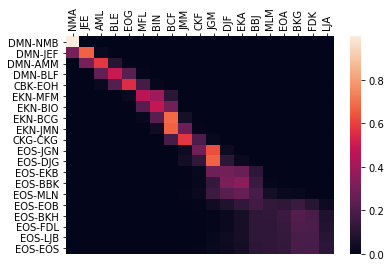

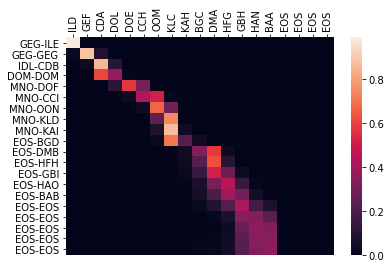

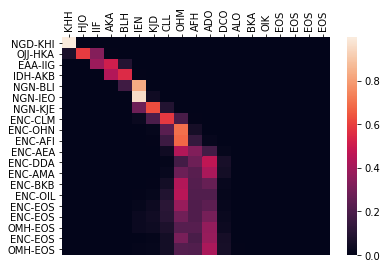

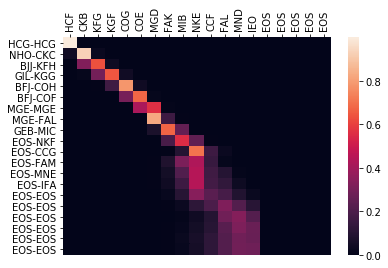

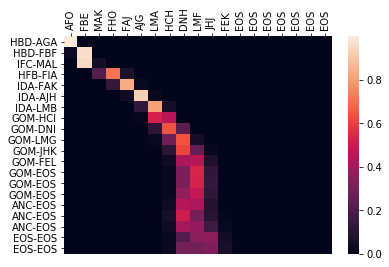



Example 1
INPUT >> NMA JEE AML BLE EOG MFL BIN BCF JMM CKF JGM DJF EKA BBJ MLM EOA BKG FDK LJA
PRED >> DMN DMN DMN DMN CBK EKN EKN EKN EKN CKG
TRUE >> NMB JEF AMM BLF EOH MFM BIO BCG JMN CKG JGN DJG EKB BBK MLN EOB BKH FDL LJB
[BLEU] 0.02

Example 2
INPUT >> ILD GEF CDA DOL DOE CCH OOM KLC KAH BGC DMA HFG GBH HAN BAA
PRED >> GEG GEG IDL DOM MNO MNO MNO MNO MNO
TRUE >> ILE GEG CDB DOM DOF CCI OON KLD KAI BGD DMB HFH GBI HAO BAB
[BLEU] 0.03

Example 3
INPUT >> KHH HJO IIF AKA BLH IEN KJD CLL OHM AFH ADO DCO ALO BKA OIK
PRED >> NGD OJJ EAA IDH NGN NGN NGN ENC ENC ENC ENC ENC ENC ENC ENC ENC ENC OMH ENC OMH
TRUE >> KHI HKA IIG AKB BLI IEO KJE CLM OHN AFI AEA DDA AMA BKB OIL
[BLEU] 0.00

Example 4
INPUT >> HCF CKB KFG KGF COG COE MGD FAK MIB NKE CCF FAL MND IEO
PRED >> HCG NHO BJJ GIL BFJ BFJ MGE MGE GEB
TRUE >> HCG CKC KFH KGG COH COF MGE FAL MIC NKF CCG FAM MNE IFA
[BLEU] 0.03

Example 5
INPUT >> AFO FBE MAK FHO FAJ AJG LMA HCH DNH LMF JHJ FEK
PRED >> HBD HBD IFC HFB IDA IDA IDA GOM GOM

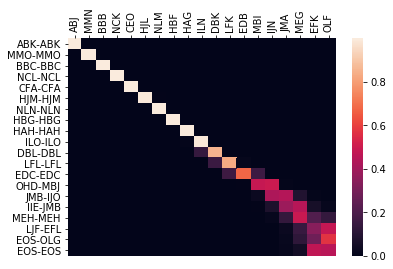

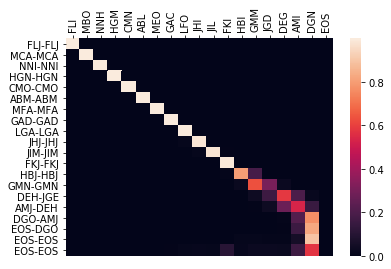

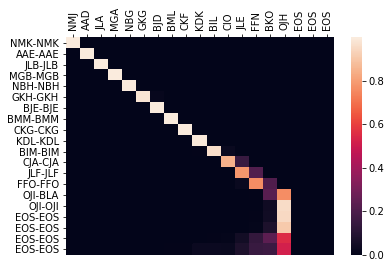

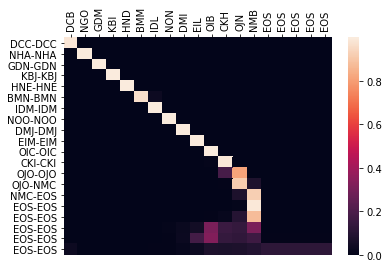

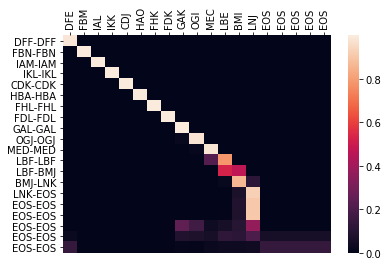



Example 1
INPUT >> ABJ MMN BBB NCK CEO HJL NLM HBF HAG ILN DBK LFK EDB MBI IJN JMA MEG EFK OLF
PRED >> ABK MMO BBC NCL CFA HJM NLN HBG HAH ILO DBL LFL EDC OHD JMB IIE MEH LJF
TRUE >> ABK MMO BBC NCL CFA HJM NLN HBG HAH ILO DBL LFL EDC MBJ IJO JMB MEH EFL OLG
[BLEU] 0.68

Example 2
INPUT >> FLI MBO NNH HGM CMN ABL MEO GAC LFO JHI JIL FKI HBI GMM JGD DEG AMI DGN
PRED >> FLJ MCA NNI HGN CMO ABM MFA GAD LGA JHJ JIM FKJ HBJ GMN DEH AMJ DGO
TRUE >> FLJ MCA NNI HGN CMO ABM MFA GAD LGA JHJ JIM FKJ HBJ GMN JGE DEH AMJ DGO
[BLEU] 0.84

Example 3
INPUT >> NMJ AAD JLA MGA NBG GKG BJD BML CKF KDK BIL CIO JLE FFN BKO OJH
PRED >> NMK AAE JLB MGB NBH GKH BJE BMM CKG KDL BIM CJA JLF FFO OJI OJI
TRUE >> NMK AAE JLB MGB NBH GKH BJE BMM CKG KDL BIM CJA JLF FFO BLA OJI
[BLEU] 0.88

Example 4
INPUT >> DCB NGO GDM KBI HND BMM IDL NON DMI EIL OIB CKH OJN NMB
PRED >> DCC NHA GDN KBJ HNE BMN IDM NOO DMJ EIM OIC CKI OJO OJO NMC
TRUE >> DCC NHA GDN KBJ HNE BMN IDM NOO DMJ EIM OIC CKI OJO NMC
[BLEU] 0.88

Exampl

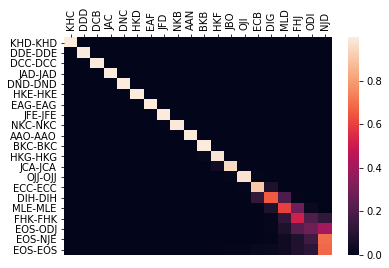

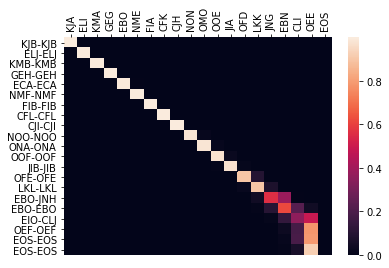

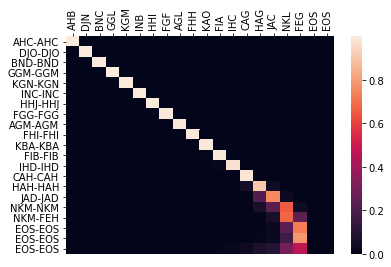

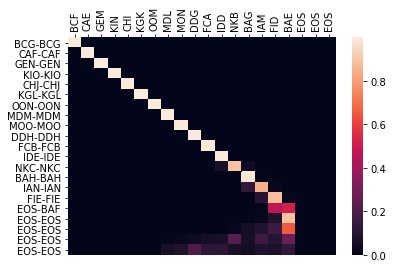

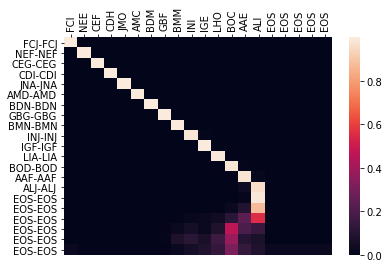



Example 1
INPUT >> KHC DDD DCB JAC DNC HKD EAF JFD NKB AAN BKB HKF JBO OJI ECB DIG MLD FHJ ODI NJD
PRED >> KHD DDE DCC JAD DND HKE EAG JFE NKC AAO BKC HKG JCA OJJ ECC DIH MLE FHK
TRUE >> KHD DDE DCC JAD DND HKE EAG JFE NKC AAO BKC HKG JCA OJJ ECC DIH MLE FHK ODJ NJE
[BLEU] 0.89

Example 2
INPUT >> KJA ELI KMA GEG EBO NME FIA CFK CJH NON OMO OOE JIA OFD LKK JNG EBN CLI OEE
PRED >> KJB ELJ KMB GEH ECA NMF FIB CFL CJI NOO ONA OOF JIB OFE LKL EBO EBO EIO OEF
TRUE >> KJB ELJ KMB GEH ECA NMF FIB CFL CJI NOO ONA OOF JIB OFE LKL JNH EBO CLJ OEF
[BLEU] 0.79

Example 3
INPUT >> AHB DJN BNC GGL KGM INB HHI FGF AGL FHH KAO FIA IHC CAG HAG JAC NKL FEG
PRED >> AHC DJO BND GGM KGN INC HHJ FGG AGM FHI KBA FIB IHD CAH HAH JAD NKM NKM
TRUE >> AHC DJO BND GGM KGN INC HHJ FGG AGM FHI KBA FIB IHD CAH HAH JAD NKM FEH
[BLEU] 0.94

Example 4
INPUT >> BCF CAE GEM KIN CHI KGK OOM MDL MON DDG FCA IDD NKB BAG IAM FID BAE
PRED >> BCG CAF GEN KIO CHJ KGL OON MDM MOO DDH FCB IDE NKC BAH IAN FIE
TRUE >> BCG CAF GEN

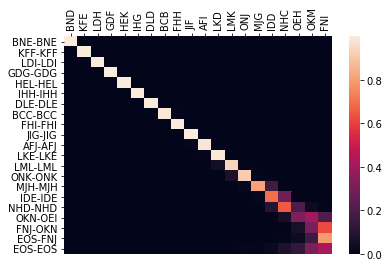

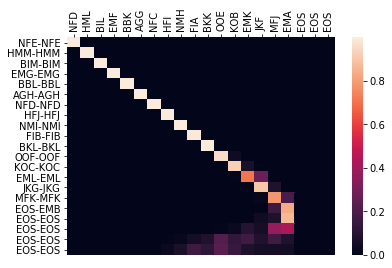

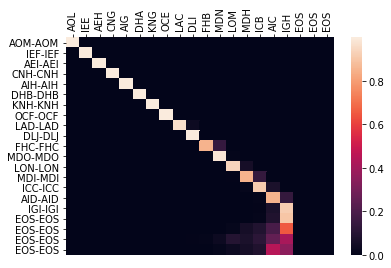

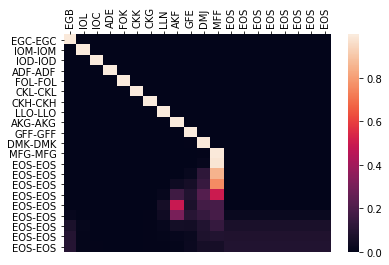

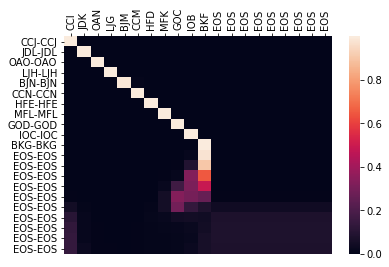



Example 1
INPUT >> BND KFE LDH GDF HEK IHG DLD BCB FHH JIF AFI LKD LMK ONJ MJG IDD NHC OEH OKM FNI
PRED >> BNE KFF LDI GDG HEL IHH DLE BCC FHI JIG AFJ LKE LML ONK MJH IDE NHD OKN FNJ
TRUE >> BNE KFF LDI GDG HEL IHH DLE BCC FHI JIG AFJ LKE LML ONK MJH IDE NHD OEI OKN FNJ
[BLEU] 0.88

Example 2
INPUT >> NFD HML BIL EMF BBK AGG NFC HFI NMH FIA BKK OOE KOB EMK JKF MFJ EMA
PRED >> NFE HMM BIM EMG BBL AGH NFD HFJ NMI FIB BKL OOF KOC EML JKG MFK
TRUE >> NFE HMM BIM EMG BBL AGH NFD HFJ NMI FIB BKL OOF KOC EML JKG MFK EMB
[BLEU] 0.94

Example 3
INPUT >> AOL IEE AEH CNG AIG DHA KNG OCE LAC DLI FHB MDN LOM MDH ICB AIC IGH
PRED >> AOM IEF AEI CNH AIH DHB KNH OCF LAD DLJ FHC MDO LON MDI ICC AID IGI
TRUE >> AOM IEF AEI CNH AIH DHB KNH OCF LAD DLJ FHC MDO LON MDI ICC AID IGI
[BLEU] 1.00

Example 4
INPUT >> EGB IOL IOC ADE FOK CKK CKG LLN AKF GFE DMJ MFF
PRED >> EGC IOM IOD ADF FOL CKL CKH LLO AKG GFF DMK MFG
TRUE >> EGC IOM IOD ADF FOL CKL CKH LLO AKG GFF DMK MFG
[BLEU] 1.00

Example 5
INPUT >> CCI

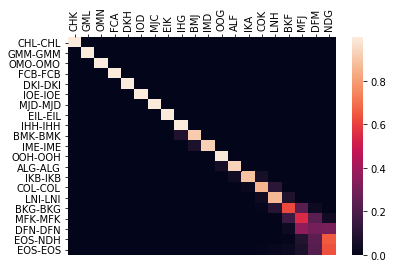

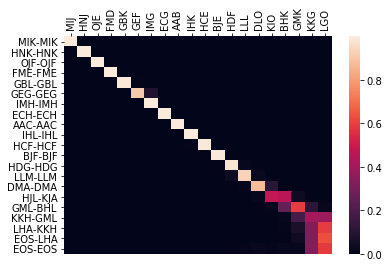

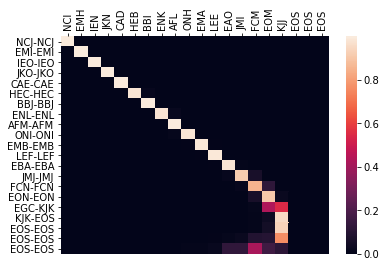

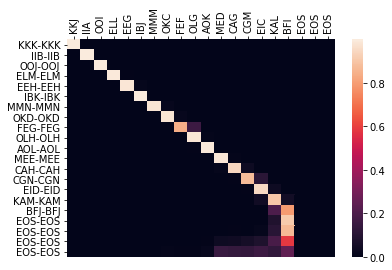

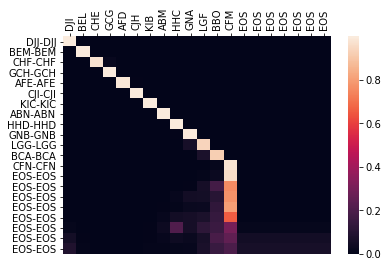



Example 1
INPUT >> CHK GML OMN FCA DKH IOD MJC EIK IHG BMJ IMD OOG ALF IKA COK LNH BKF MFJ DFM NDG
PRED >> CHL GMM OMO FCB DKI IOE MJD EIL IHH BMK IME OOH ALG IKB COL LNI BKG MFK DFN
TRUE >> CHL GMM OMO FCB DKI IOE MJD EIL IHH BMK IME OOH ALG IKB COL LNI BKG MFK DFN NDH
[BLEU] 0.95

Example 2
INPUT >> MIJ HNJ OJE FMD GBK GEF IMG ECG AAB IHK HCE BJE HDF LLL DLO KIO BHK GMK KKG LGO
PRED >> MIK HNK OJF FME GBL GEG IMH ECH AAC IHL HCF BJF HDG LLM DMA HJL GML KKH LHA
TRUE >> MIK HNK OJF FME GBL GEG IMH ECH AAC IHL HCF BJF HDG LLM DMA KJA BHL GML KKH LHA
[BLEU] 0.81

Example 3
INPUT >> NCI EMH IEN JKN CAD HEB BBI ENK AFL ONH EMA LEE EAO JMI FCM EOM KJJ
PRED >> NCJ EMI IEO JKO CAE HEC BBJ ENL AFM ONI EMB LEF EBA JMJ FCN EON EGC KJK
TRUE >> NCJ EMI IEO JKO CAE HEC BBJ ENL AFM ONI EMB LEF EBA JMJ FCN EON KJK
[BLEU] 0.89

Example 4
INPUT >> KKJ IIA OOI ELL EEG IBJ MMM OKC FEF OLG AOK MED CAG CGM EIC KAL BFI
PRED >> KKK IIB OOJ ELM EEH IBK MMN OKD FEG OLH AOL MEE CAH CGN EID KAM BFJ
TRUE >> KKK

In [179]:
s2s.train(nEpochs=5, epochSize=500, printEvery=50, evalSize=5)
# heatmap:
#   x-labels: on top, the source sentence (input).
#   y-labels: on left, prediction-target word per row (predictions-targets).

In [180]:
s2s.evaluate(nBatches=50, saveResults=True)

Average BLEU score over 1600 examples is 0.9731
